In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import os
from utils import to_device,DeviceDataLoader
from tqdm.notebook import tqdm
from time import sleep

In [2]:
data = './dataset/COVID-19_Radiography_Dataset'
class_names = os.listdir(data)

In [3]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.empty_cache()

In [4]:
IMAGE_SIZE = 200
BATCH_SIZE = 64
TRAIN_VAL_SPLIT = 0.15
EPOCHS_AUTOE = 20

In [5]:
dataset = ImageFolder(data,transform=transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.ToTensor()]))

Image Shape :-  torch.Size([3, 200, 200])


Text(0.5, 1.0, 'COVID')

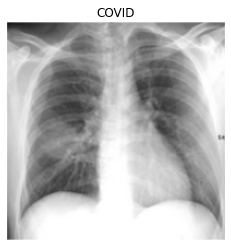

In [6]:
img,label = dataset[5]
print("Image Shape :- ",img.shape)
plt.imshow(img.permute(1,2,0).numpy(),cmap='gray')
plt.axis("off")
plt.title(class_names[label])

In [7]:
def Split_index(n,val_percent):
    n_val = int(val_percent*n)
    index = np.random.permutation(n)
    return index[n_val:],index[:n_val]

In [8]:
train_indices, val_indices = Split_index(len(dataset),val_percent=TRAIN_VAL_SPLIT)
print(len(train_indices),len(val_indices))
print(train_indices,val_indices)

17991 3174
[19741  1362 12543 ...  5390   860 15795] [21113 10611  2127 ... 19215  2699 12589]


In [9]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [10]:
train_dl = DataLoader(dataset,batch_size =BATCH_SIZE,sampler=train_sampler,num_workers=2,pin_memory=True)
val_dl = DataLoader(dataset,batch_size =BATCH_SIZE,sampler=val_sampler,num_workers=2,pin_memory=True)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
dataiter = iter(train_dl)
img, label = dataiter.next()
print(torch.min(img),torch.max(img))

tensor(0.) tensor(1.)


In [14]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [13]:
torch.cuda.memory_allocated()

0

``` Python
dummy_encoder = nn.Sequential(
    nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),
    nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU() 
)

for img,label in train_dl:
    print("Input Image Shape :- ",img.shape)
    out = dummy_encoder(img)
    print("Output Shape :- ",out.shape)
    break

temp_img = torch.empty(64,256,13,13)
dummy_decoder = nn.Sequential(
    nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32,3,kernel_size=3,stride=2,padding=1,output_padding=1),
    nn.BatchNorm2d(3),
    nn.Sigmoid()
)

print('Input Encoded Image :- ',temp_img.shape)
outd = dummy_decoder(temp_img)
print("Decoded Image Shape :- ",outd.shape)
```

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,3,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
    
    def forward(self,data,MODE):
        if MODE=='Train':
            encoded = self.Encoder(data)
            decoded = self.Decoder(encoded)
            return decoded
        elif MODE=='Encode':
            encoded = self.Encoder(data)
            return encoded

In [15]:
AutoEn = to_device(AutoEncoder(),device)
learning_rate_AUTOE = 0.001
optimizerAUTOE = torch.optim.Adam(AutoEn.parameters(),lr=learning_rate_AUTOE)
criterion = nn.MSELoss()

In [16]:
Losses = []
OUTPUTS = []
for epoch in range(EPOCHS_AUTOE):
    epoch_loss = []
    with tqdm(train_dl,unit="B",unit_scale=True,unit_divisor=1024) as tepoch:
        for img,l in tepoch:
            tepoch.set_description(f"EPOCHS [{epoch+1}]")
            img = img.to(device)
            output = AutoEn(img,MODE='Train')
            loss = criterion(output,img)
            epoch_loss.append(loss)
            optimizerAUTOE.zero_grad()
            loss.backward()
            optimizerAUTOE.step()
            train_loss_epoch = torch.stack(epoch_loss).mean().item()
            tepoch.set_postfix(TrainingLoss=loss.item(),Batch_Loss=train_loss_epoch)
        Losses.append(train_loss_epoch)
        OUTPUTS.append(output)        

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

  0%|          | 0.00/282 [00:00<?, ?B/s]

Text(0.5, 1.0, 'Epoch Vs. Loss for Autoencoder')

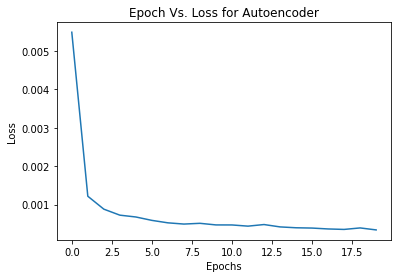

In [17]:
plt.plot(range(EPOCHS_AUTOE),Losses)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title("Epoch Vs. Loss for Autoencoder")

In [18]:
PATH = './models/AutoEn_1'
torch.save(AutoEn,PATH)

- To Load the Model
``` Python
model = torch.load(PATH)
model = to_device(model,device) #Taking it to GPU
```